# Convex approximate dynamic programming

We consider a stochastic control problem of the form
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \underset{T \to \infty}\lim {\mathbb E} \left[\frac{1}{T} \sum_{t=0}^{T-1} \|{x_t}\|_2^2 + \|{\phi(x_t)}\|_2^2\right]\\[.2cm]
\mbox{subject to} & x_{t+1} = Ax_t + B\phi(x_t) + \omega_t,
\end{array}
\label{eq:adp}
\end{equation}
where $x_t\in\mathbf{R}^n$ is the state, $\phi:\mathbf{R}^n \to \mathcal U \subseteq \mathbf{R}^m$ is
the policy, $\mathcal U$ is a convex set representing the allowed set of controls,
and $\omega_t\in\Omega$ is a (random, i.i.d.) disturbance.
Here the variable is the policy $\phi$, and the expectation is taken over
disturbances and the initial state $x_0$. If $\mathcal U$ is not an affine
set, then this problem is in general very difficult to solve.

A common heuristic for solving stochastic control problems is
approximate dynamic programming (ADP), which parametrizes $\phi$
and replaces the minimization over functions $\phi$ with a minimization over parameters.
In this example, we take $\mathcal U$ to be the unit ball and we represent $\phi$
as a particular quadratic *control-Lyapunov* policy.
Evaluating $\phi$ corresponds to solving the SOCP
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & u^T P u + x_t^T Q u + q^T u \\
\mbox{subject to} & \|{u}\|_2 \leq 1,
\end{array}
\label{eq:policy}
\end{equation}
with variable $u$ and parameters $P$, $Q$, $q$, and $x_t$. We can run
gradient descent (SGD) on $P$, $Q$, and $q$ to
approximately solve the original problem, which requires requires differentiating
through the quadratic policy. Note that if $u$ were unconstrained, the original problem
could be solved exactly, via linear quadratic regulator (LQR) theory.

In [1]:
import cvxpy as cp
import numpy as np
import torch
from scipy.linalg import solve_discrete_are
from scipy.linalg import sqrtm

from cvxpylayers.torch import CvxpyLayer

# Generate data
torch.manual_seed(1)
np.random.seed(1)

n = 2
m = 3

A = np.eye(n) + 1e-2 * np.random.randn(n, n)
B = 1e-2 / 3 * np.random.randn(n, m)
Q = np.eye(n)
R = np.eye(m)

# Compute LQR control policy
P_lqr = solve_discrete_are(A, B, Q, R)
P = R + B.T@P_lqr@B
P_sqrt_lqr = sqrtm(P)

# Construct CVXPY problem and layer
x_cvxpy = cp.Parameter((n, 1))
P_sqrt_cvxpy = cp.Parameter((m, m))
P_21_cvxpy = cp.Parameter((n, m))
q_cvxpy = cp.Parameter((m, 1))

u_cvxpy = cp.Variable((m, 1))
y_cvxpy = cp.Variable((n, 1))

objective = .5 * cp.sum_squares(P_sqrt_cvxpy @ u_cvxpy) + x_cvxpy.T @ y_cvxpy + q_cvxpy.T @ u_cvxpy
problem = cp.Problem(cp.Minimize(objective), [cp.norm(u_cvxpy) <= 1, y_cvxpy == P_21_cvxpy @ u_cvxpy])
assert problem.is_dpp()
policy = CvxpyLayer(
    problem, [x_cvxpy, P_sqrt_cvxpy, P_21_cvxpy, q_cvxpy], [u_cvxpy])

Below, we train the policy and plot the estimated average cost for each iteration of
SGD for a numerical example, with $x \in
\mathbf{R}^2$ and $u \in \mathbf{R}^3$, a time horizon of $T=25$, and a batch
size of $8$. We initialize our policy's parameters with the LQR solution,
ignoring the constraint on $u$.

In [2]:
import matplotlib.pyplot as plt

def train(iters):
    # Initialize with LQR control lyapunov function
    P_sqrt = torch.from_numpy(P_sqrt_lqr).requires_grad_(True)
    P_21 = torch.from_numpy(A.T @ P_lqr @ B).requires_grad_(True)
    q = torch.zeros((m, 1), dtype=torch.double, requires_grad=True)
    variables = [P_sqrt, P_21, q]
    A_tch, B_tch, Q_tch, R_tch = map(torch.from_numpy, [A, B, Q, R])

    def g(x, u):
        return (x.t() @ Q_tch @ x + u.t() @ R_tch @ u).squeeze()

    def evaluate(x0, P_sqrt, P_21, q, T):
        x = x0
        cost = 0.
        for _ in range(T):
            u, = policy(x, P_sqrt, P_21, q)
            cost += g(x, u) / T
            x = A_tch @ x + B_tch @ u + .2 * torch.randn(n, 1).double()
        return cost

    def eval_loss(N=8, T=25):
        return sum([evaluate(torch.zeros(n, 1).double(), P_sqrt, P_21, q, T=T)
                    for _ in range(N)]) / N

    results = []
    optimizer = torch.optim.SGD(variables, lr=.02, momentum=.9)
    for i in range(iters):
        # use same seeds each iteration to get pretty training plot
        torch.manual_seed(1)
        np.random.seed(1)
        optimizer.zero_grad()
        loss = eval_loss()
        loss.backward()
        optimizer.step()
        results.append(loss.item())
        print("(iter %d) loss: %g " % (i, results[-1]))
    return results


results = train(iters=100)

(iter 0) loss: 1.51906 
(iter 1) loss: 1.51596 
(iter 2) loss: 1.51004 
(iter 3) loss: 1.50076 
(iter 4) loss: 1.48964 
(iter 5) loss: 1.47732 
(iter 6) loss: 1.46409 
(iter 7) loss: 1.44985 
(iter 8) loss: 1.43349 
(iter 9) loss: 1.41393 
(iter 10) loss: 1.39383 
(iter 11) loss: 1.37273 
(iter 12) loss: 1.35031 
(iter 13) loss: 1.32644 
(iter 14) loss: 1.2979 
(iter 15) loss: 1.26749 
(iter 16) loss: 1.23994 
(iter 17) loss: 1.21162 
(iter 18) loss: 1.18454 
(iter 19) loss: 1.15832 
(iter 20) loss: 1.13336 
(iter 21) loss: 1.10918 
(iter 22) loss: 1.08801 
(iter 23) loss: 1.07002 
(iter 24) loss: 1.05461 
(iter 25) loss: 1.04056 
(iter 26) loss: 1.02755 
(iter 27) loss: 1.0159 
(iter 28) loss: 1.00493 
(iter 29) loss: 0.995569 
(iter 30) loss: 0.987571 
(iter 31) loss: 0.980465 
(iter 32) loss: 0.974158 
(iter 33) loss: 0.968241 
(iter 34) loss: 0.962846 
(iter 35) loss: 0.958006 
(iter 36) loss: 0.953747 
(iter 37) loss: 0.949987 
(iter 38) loss: 0.946659 
(iter 39) loss: 0.943703 
(

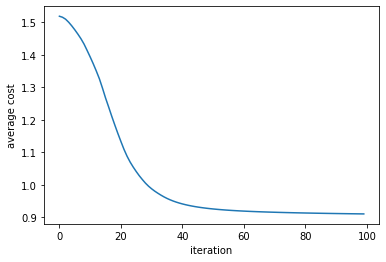

In [3]:
plt.figure()
plt.plot(results)
plt.xlabel('iteration')
plt.ylabel('average cost')
plt.savefig("adp.pdf")
plt.show()